In [1]:
!pip install -q tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 49kB/s 
     |████████████████████████████████| 3.1MB 34.6MB/s 
     |████████████████████████████████| 501kB 52.3MB/s 


In [0]:
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers


np.random.seed(1)
sns.set(style="white", context="notebook", palette="pastel")

In [0]:
# Load
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [0]:
# Preprocess
x_train = train.drop(labels=["label"], axis=1)
x_train /= 255.0
x_train = x_train.values.reshape(-1, 28, 28, 1)

y_train = train["label"]
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)

test /= 255.0
test = test.values.reshape(-1, 28, 28, 1)

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=1
)

In [5]:
# Build model
model = tf.keras.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(28, 28, 1)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=32, kernel_size=3, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=32, kernel_size=5, strides=2, padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(filters=64, kernel_size=3, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=64, kernel_size=3, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=64, kernel_size=5, strides=2, padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(10, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0

In [0]:
# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [0]:
# Generate augmented data
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1
)

In [0]:
# Create callback for model
annealer = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

In [9]:
# Run the model
batch_size = 60
steps_per_epoch = x_train.shape[0] // batch_size
history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    verbose=1,
    callbacks=[annealer],
    validation_data=(x_val, y_val),
)

W0806 21:31:59.399471 140594318391168 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
630/630 [==============================] - 23s 36ms/step - loss: 0.4750 - accuracy: 0.8540 - val_loss: 0.0512 - val_accuracy: 0.9848
Epoch 2/30
630/630 [==============================] - 17s 28ms/step - loss: 0.1410 - accuracy: 0.9588 - val_loss: 0.0453 - val_accuracy: 0.9848
Epoch 3/30
630/630 [==============================] - 17s 28ms/step - loss: 0.1065 - accuracy: 0.9677 - val_loss: 0.0374 - val_accuracy: 0.9900
Epoch 4/30
630/630 [==============================] - 18s 28ms/step - loss: 0.0922 - accuracy: 0.9720 - val_loss: 0.0283 - val_accuracy: 0.9907
Epoch 5/30
630/630 [==============================] - 18s 28ms/step - loss: 0.0790 - accuracy: 0.9770 - val_loss: 0.0329 - val_accuracy: 0.9895
Epoch 6/30
630/630 [==============================] - 17s 28ms/step - loss: 0.0706 - accuracy: 0.9798 - val_loss: 0.0317 - val_accuracy: 0.9914
Epoch 7/30
630/630 [==============================] - 17s 28ms/step - loss: 0.0659 - accuracy: 0.9808 - val_loss: 0.0253 - val_accuracy:

In [0]:
# Save weights
model.save_weights("weights.h5")

In [11]:
# Evaluate model
loss, accuracy = model.evaluate(x_val, y_val, verbose=0)
print("Loss: {0:.6f}, Accuracy: {1:.6f}".format(loss, accuracy))

Loss: 0.011945, Accuracy: 0.996190


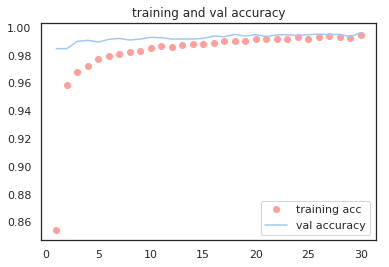

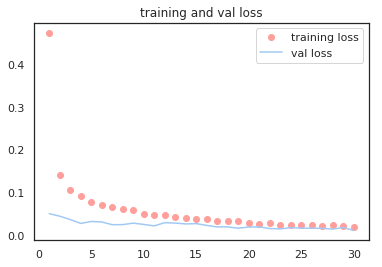

<Figure size 432x288 with 0 Axes>

In [12]:
# Plot accuracy and loss
epochs = range(1, len(history.history["accuracy"]) + 1)
plt.plot(epochs, history.history["accuracy"], "ro", label="training acc")
plt.plot(epochs, history.history["val_accuracy"], "b", label="val accuracy")
plt.title("training and val accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, history.history["loss"], "ro", label="training loss")
plt.plot(epochs, history.history["val_loss"], "b", label="val loss")
plt.title("training and val loss")
plt.legend()
plt.figure()

plt.show()

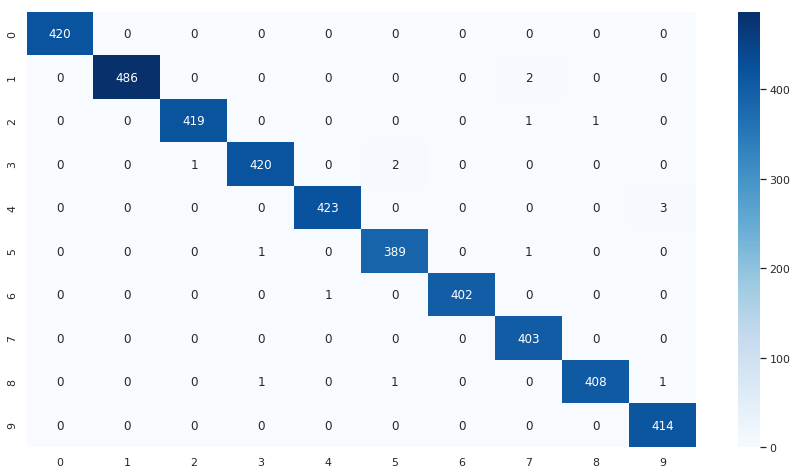

In [16]:
# Show confusion matrix
y_hat = model.predict(x_val)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_val, axis=1)
cm = tf.math.confusion_matrix(y_true, y_pred)

plt.figure(figsize=(15,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")